In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.utils.ensemble import sorted_neurons
from nengo.utils.matplotlib import rasterplot

# Transformations
from neuroptimiser.utils import tro2s, trs2o

from ioh import get_problem


In [10]:

PROBLEM_ID      = 13  # Problem ID from the IOH framework
PROBLEM_INS     = 1  # Problem instance
NUM_DIMENSIONS  = 2  # Number of dimensions for the problem

problem         = get_problem(fid=PROBLEM_ID, instance=PROBLEM_INS, dimension=NUM_DIMENSIONS)
problem.reset()
print(problem)

X_LOWER_BOUND   = problem.bounds.lb
X_UPPER_BOUND   = problem.bounds.ub
X_INITIAL_GUESS = np.random.uniform(X_LOWER_BOUND, X_UPPER_BOUND, NUM_DIMENSIONS)


<RealSingleObjectiveProblem 13. SharpRidge (iid=1 dim=2)>


In [17]:

# Evaluate the objective function
def f_obj(t, state_vector):
    """Evaluate the objective function at the given state vector."""
    v       = np.clip(state_vector, -1.0, 1.0)  # Ensure within bounds, consider toroidal space later
    x_vals  = trs2o(v, X_LOWER_BOUND, X_UPPER_BOUND)
    # Implement here the transformation for integer variables if needed
    return problem(x_vals)

# Create the Nengo model
model = nengo.Network(label="nNeurOpti V1", seed=69)
with model:
    # INITIALISATION
    # --------------------------------------------------------------
    # Input nodes for the bounds and initial guess
    # input_x_l    = nengo.Node(label="x_l", output=X_LOWER_BOUND)
    # input_x_u    = nengo.Node(label="x_u", output=X_UPPER_BOUND)
    # input_x_0    = nengo.Node(label="x_0", output=X_INITIAL_GUESS)

    # State ensemble
    ens_lif     = nengo.Ensemble(n_neurons=50 * NUM_DIMENSIONS,
                                 dimensions=NUM_DIMENSIONS,
                                 # encoders=nengo.dists.UniformHypersphere(surface=True),
                                 radius=0.5 * np.sqrt(NUM_DIMENSIONS),  # To cover the [-1, 1] space
                                    # neuron_type=nengo.AdaptiveLIF(),
                                 intercepts=nengo.dists.Uniform(-1.0, 1.0),
                                 max_rates=nengo.dists.Uniform(20,220),
                                 # noise=nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.5), seed=42),
                                 label="ens_lif")

    # Recurrent connection to hold the state
    tau     = 0.05
    nengo.Connection(ens_lif, ens_lif, transform=np.eye(NUM_DIMENSIONS), synapse=tau)


    # Encoding function for the initial guess in state space within [-1, 1]
    v0_state    = tro2s(X_INITIAL_GUESS, X_LOWER_BOUND, X_UPPER_BOUND)
    input_v0    = nengo.Node(label="v0_state", output=v0_state.copy())

    nengo.Connection(input_v0, ens_lif, synapse=None)

    # LOCAL STATE
    state = {
        "best_v": v0_state.copy(),
        "best_f": f_obj(None, v0_state),
    }

    # Connect to the objective function node
    obj_node    = nengo.Node(label="f_obj", output=f_obj, size_in=NUM_DIMENSIONS, size_out=1)
    nengo.Connection(ens_lif, obj_node, synapse=0)

    # ====
    def local_selector(t, x):
        v       = x[:NUM_DIMENSIONS]
        fv      = float(x[NUM_DIMENSIONS])
        if fv < state["best_f"] and t >= 0.01:  # Avoid initial transient
            state["best_f"] = fv
            state["best_v"] = v.copy()

        if state["best_v"] is None:
            return np.concatenate((v, [fv]))
        else:
            return np.concatenate((state["best_v"], [state["best_f"]]))

    selector_node   = nengo.Node(
        label="local_best",
        output=local_selector,
        size_in=NUM_DIMENSIONS + 1,
        size_out=NUM_DIMENSIONS + 1,
    )

    nengo.Connection(ens_lif, selector_node[:NUM_DIMENSIONS], synapse=0)
    nengo.Connection(obj_node, selector_node[NUM_DIMENSIONS], synapse=0)
    # ====

    # Controller towards the best-so-far
    eta = 0.2 # Learning rate or movement rate towards the best
    def controller(t, x):
        best_v  = x[:NUM_DIMENSIONS]
        curr_v  = x[NUM_DIMENSIONS:]
        return eta * (best_v - curr_v)

    control_node = nengo.Node(
        label="controller",
        output=controller,
        size_in=2 * NUM_DIMENSIONS,
        size_out=NUM_DIMENSIONS,
    )

    nengo.Connection(selector_node[:NUM_DIMENSIONS], control_node[:NUM_DIMENSIONS], synapse=0)
    nengo.Connection(ens_lif, control_node[NUM_DIMENSIONS:], synapse=0)      # Current state vector

    nengo.Connection(control_node, ens_lif, synapse=0.01)  # Apply control to the ensemble

    fbest_only = nengo.Node(
        size_in=NUM_DIMENSIONS+1,
        size_out=1,
        output=lambda t, x: x[-1]
    )
    nengo.Connection(selector_node, fbest_only, synapse=0)

    # input_probe = nengo.Probe(v_0, synapse=0.01)
    ens_lif_val = nengo.Probe(ens_lif, synapse=0.01)  # 10ms filter
    obj_val     = nengo.Probe(obj_node, synapse=0.01)
    fbest_val   = nengo.Probe(fbest_only, synapse=0.01)
    ens_lif_spk = nengo.Probe(ens_lif.neurons)  # Collect the spikes


In [18]:
simulation_time = 10.0  # seconds

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(simulation_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

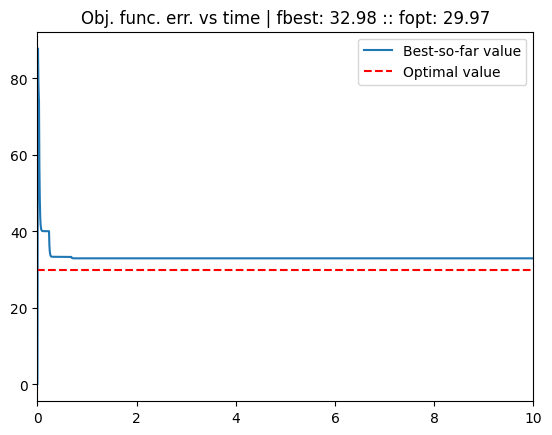

In [19]:
plt.figure()
# plt.plot(sim.trange(), sim.data[obj_val], label="Objective value")
plt.plot(sim.trange(), sim.data[fbest_val], label="Best-so-far value")
plt.hlines(problem.optimum.y, 0, simulation_time, colors="r", linestyles="dashed", label="Optimal value")
plt.xlim(0, simulation_time)
# plt.yscale("log")
plt.legend()
plt.title(f"Obj. func. err. vs time | fbest: {sim.data[fbest_val][-1][0]:.2f} :: fopt: {problem.optimum.y}")
plt.show()

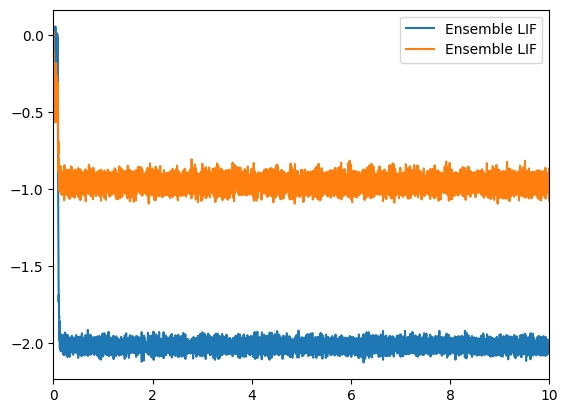

In [6]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[ens_lif_val], label="Ensemble LIF")
# plt.plot(sim.trange(), sim.data[input_probe], "r", label="Input")
plt.xlim(0, simulation_time)
plt.legend()
plt.show()

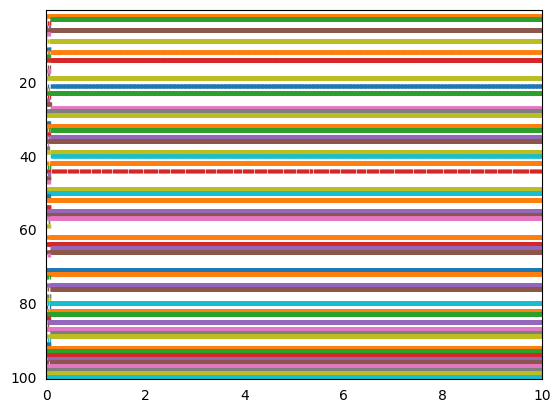

In [7]:
# Plot the spiking output of the ensemble
plt.figure()
rasterplot(sim.trange(), sim.data[ens_lif_spk])
plt.xlim(0, simulation_time)
plt.show()


In [8]:
# # For interest's sake, you can also sort by encoder
# indices = sorted_neurons(ens_lif, sim, iterations=250)
# plt.figure()
# rasterplot(sim.trange(), sim.data[ens_lif_spk][:, indices])
# plt.xlim(0, simulation_time)
# plt.show()